In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import nltk

In [3]:
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [4]:
data=pd.read_csv('datasets/tweets.csv')

In [5]:
#get stopword list
sw_list=stopwords.words('english')
sw_list.remove('not')
sw_list.remove('no')
sw_list.remove('against')

In [6]:
#Initialize lemmatizer
lemmatizer=WordNetLemmatizer()

In [7]:
def nltk_wn_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:                    
    return None

In [8]:
def lemmatize_sentence(sentence):
    tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_wn_tag(x[1])), tagged)
    lemmatized_words=[]
    for word, tag in wordnet_tagged:
        if word not in sw_list:
            if tag is None:                        
                lemmatized_words.append(word)
            else:
                lemmatized_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_words)

In [9]:
def clean_tweets(tweet):
    #remove RT(retweet tag)
    tweet=re.sub(r"RT @","@",tweet)
    #remove pings
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    #remove URLs
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    #remove special characters
    tweet = re.sub(r"[^a-zA-Z]", ' ', tweet)
    #convert to lower case
    tweet=tweet.lower()
    #remove extra white spaces
    tweet = re.sub(r" +",' ', tweet)
    #lemmatization of tweet and removing stopwords
    lemmatized_tweet=lemmatize_sentence(tweet)
    #remove extra white spaces
    tweet = re.sub(r" +", ' ', tweet)
    return lemmatized_tweet.strip()

In [10]:
data['tweets']=[clean_tweets(tweet) for tweet in data['tweets']]

In [11]:
data.replace("",np.nan,inplace=True)
data.dropna(subset=['tweets'],inplace=True)
data.eq('').sum()

tweets    0
labels    0
dtype: int64

In [39]:
from sklearn.model_selection import train_test_split
X=data['tweets']
y=data['labels']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=7)

In [13]:
max_len=max(len(tweet.split(' ')) for tweet in X_train)

In [14]:
max_len

24

In [15]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train,3)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [17]:
text_vectorizer = TextVectorization(max_tokens=None,
                                    output_mode="int",
                                    output_sequence_length=max_len)

In [18]:
X_train.values

array(['obama admin cry tax increase applaud china lower tax spur econ grwth make tcot',
       'barack obama longboard package core truck mm bigfoot wheel new addition bigfoot collection',
       'edshow whenever obama tell truth gop boo hoo hoo call bully', ...,
       'genius man sing else really obama',
       'mitt romney obama spend much time harvard also year less via',
       'en el backstage de los kca harry le pregunto michelle obama como hacia para ordenar pizza desde la casa blanca'],
      dtype=object)

In [19]:
text_vectorizer.adapt(X_train.values)

In [20]:
from tensorflow.keras import layers

In [21]:
len(text_vectorizer.get_vocabulary())

2485

In [22]:
embedding=layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),
                            output_dim=128,
                            embeddings_initializer='uniform',
                            input_length=max_len)
embedding

In [23]:
model_1=Sequential()
model_1.add(layers.Input(shape=(1,),dtype="string"))
model_1.add(text_vectorizer)
model_1.add(embedding)
model_1.add(layers.GlobalAveragePooling1D())
model_1.add(layers.Dense(activation='relu',units=64))
model_1.add(layers.Dropout(0.2))
model_1.add(layers.Dense(activation='relu',units=32))
model_1.add(layers.Dense(activation='softmax',units=3))
model_1.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           318080    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 9

In [25]:
y_train.shape

(1085, 3)

In [26]:
model_1_history = model_1.fit(X_train,y_train,
                              epochs=20)

Epoch 1/20
34/34 [==============================] - 0s 3ms/step - loss: 0.8525 - accuracy: 0.6691
Epoch 2/20
34/34 [==============================] - 0s 3ms/step - loss: 0.7233 - accuracy: 0.6839
Epoch 3/20
34/34 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.7069
Epoch 4/20
34/34 [==============================] - 0s 3ms/step - loss: 0.5340 - accuracy: 0.7908
Epoch 5/20
34/34 [==============================] - 0s 3ms/step - loss: 0.4214 - accuracy: 0.8406
Epoch 6/20
34/34 [==============================] - 0s 4ms/step - loss: 0.3290 - accuracy: 0.8876
Epoch 7/20
34/34 [==============================] - 0s 3ms/step - loss: 0.2740 - accuracy: 0.8977
Epoch 8/20
34/34 [==============================] - 0s 3ms/step - loss: 0.2219 - accuracy: 0.9161
Epoch 9/20
34/34 [==============================] - 0s 3ms/step - loss: 0.1927 - accuracy: 0.9161
Epoch 10/20
34/34 [==============================] - 0s 2ms/step - loss: 0.1592 - accuracy: 0.9263
Epoch 11/20
34/34 [

In [40]:
y_test=to_categorical(y_test,3)
y_predictions=(model_1.predict(X_test) > 0.5).astype("int32")

In [38]:
y_test.shape

(272, 3, 3)

In [41]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       182
           1       0.75      0.68      0.71        78
           2       0.57      0.33      0.42        12

   micro avg       0.83      0.82      0.82       272
   macro avg       0.73      0.64      0.67       272
weighted avg       0.82      0.82      0.82       272
 samples avg       0.82      0.82      0.82       272



In [42]:
print(accuracy_score(y_test,y_predictions))

0.8198529411764706


In [44]:
losses=pd.DataFrame(model_1_history.history)

<AxesSubplot:>

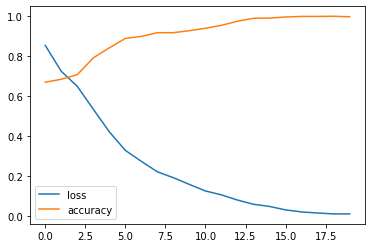

In [45]:
losses.plot()